In [6]:
import os
import scipy.io
import numpy as np
import scipy.linalg
import matplotlib.pyplot as plt

In [7]:
# Load training data from MAT file
R = scipy.io.loadmat('movie_data/movie_train.mat')['train']

# Load validation data from CSV
val_data = np.loadtxt('movie_data/movie_validate.txt', dtype=int, delimiter=',')

In [8]:
# Helper method to get training accuracy
def get_train_acc(R, user_vecs, movie_vecs):
    num_correct, total = 0, 0
    for i in range(R.shape[0]):
        for j in range(R.shape[1]):
            if not np.isnan(R[i, j]):
                total += 1
                if np.dot(user_vecs[i], movie_vecs[j])*R[i, j] > 0:
                    num_correct += 1
    return num_correct/total

# Helper method to get validation accuracy
def get_val_acc(val_data, user_vecs, movie_vecs):
    num_correct = 0
    for val_pt in val_data:
        user_vec = user_vecs[val_pt[0]-1]
        movie_vec = movie_vecs[val_pt[1]-1]
        est_rating = np.dot(user_vec, movie_vec)
        if est_rating*val_pt[2] > 0:
            num_correct += 1
    return num_correct/val_data.shape[0]

# Helper method to get indices of all rated movies for each user,
# and indices of all users who have rated that title for each movie
def get_rated_idxs(R):
    user_rated_idxs, movie_rated_idxs = [], []
    for i in range(R.shape[0]):
        user_rated_idxs.append(np.argwhere(~np.isnan(R[i, :])).reshape(-1))
    for j in range(R.shape[1]):
        movie_rated_idxs.append(np.argwhere(~np.isnan(R[:, j])).reshape(-1))
    return np.array(user_rated_idxs), np.array(movie_rated_idxs)

In [9]:
# Part (c): SVD to learn low-dimensional vector representations
def svd_lfm(R):

    # Fill in the missing values in R
    ##### TODO(c): Your Code Here #####
    for i in range(len(R)):
        for j in range(len(R[0])):
            if np.isnan(R[i][j]):
                R[i][j] = 0

    # Compute the SVD of R
    ##### TODO(c): Your Code Here #####
    u, sig, vt = scipy.linalg.svd(R, full_matrices = False)

    # Construct user and movie representations
    ##### TODO(c): Your Code Here #####
    user_vecs = u @ np.diagflat(sig)
    movie_vecs = vt.T
    return user_vecs, movie_vecs

In [10]:
# Part (d): Compute the training MSE loss of a given vectorization
def get_train_mse(R, user_vecs, movie_vecs):

    # Compute the training MSE loss
    ##### TODO(d): Your Code Here #####
    mse_loss = 0
    for i in range(len(R)):
        for j in range(len(R[0])):
            if not np.isnan(R[i][j]):
                mse_loss += (np.dot(user_vecs[i], movie_vecs[j]) - R[i][j]) ** 2
    return mse_loss

In [12]:
# Part (e): Compute training MSE and val acc of SVD LFM for various d
user_vecs, movie_vecs = svd_lfm(np.copy(R))
tmse = []
tacc = []
vacc = []
for i in [2, 5, 10, 20]:
    train_mse = get_train_mse(np.copy(R), user_vecs[:, :i], movie_vecs[:, :i])
    train_acc = get_train_acc(np.copy(R), user_vecs[:, :i], movie_vecs[:, :i])
    val_acc = get_val_acc(val_data, user_vecs[:, :i], movie_vecs[:, :i])
    tmse += [train_mse]
    tacc += [train_acc]
    vacc += [val_acc]

Text(0.5,1,'training MSE as a function of d')

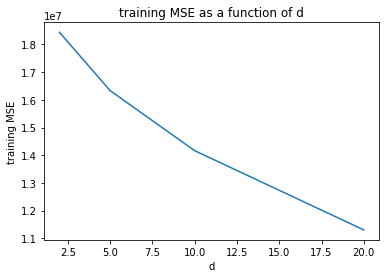

In [14]:
##### TODO(e): Generate plots of train MSE and train/val accuracy for different d #####
plt.plot([2, 5, 10, 20], tmse)
plt.xlabel('d')
plt.ylabel('training MSE')
plt.title('training MSE as a function of d')

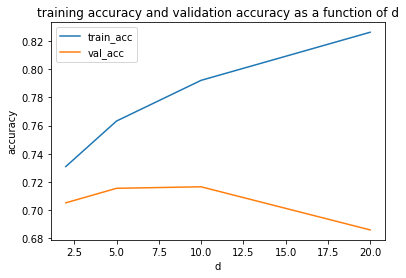

In [16]:
plt.plot([2, 5, 10, 20], tacc)
plt.plot([2, 5, 10, 20], vacc)
plt.ylabel('accuracy')
plt.xlabel('d')
plt.title('training accuracy and validation accuracy as a function of d')
plt.legend(('train_acc', 'val_acc'))

d = 10 leads to optimal performance

In [61]:
# Part (f): Learn better user/movie vector representations by minimizing loss
best_d = 10 #TODO(f): Use best from part (e)
np.random.seed(20)
user_vecs = np.random.random((R.shape[0], best_d))
movie_vecs = np.random.random((R.shape[1], best_d))
user_rated_idxs, movie_rated_idxs = get_rated_idxs(np.copy(R))

<ipython-input-8-62e768730efe>:31: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array(user_rated_idxs), np.array(movie_rated_idxs)


In [62]:
# Part (f): Function to update user vectors
def update_user_vecs(user_vecs, movie_vecs, R, user_rated_idxs):

    # Update user_vecs to the loss-minimizing value
    ##### TODO(f): Your Code Here #####
    for i in range(len(user_rated_idxs)):
        temp = R[i][user_rated_idxs[i][0]] * movie_vecs[user_rated_idxs[i][0]]
        temp2 = np.outer(movie_vecs[user_rated_idxs[i][0]], movie_vecs[user_rated_idxs[i][0]].T)
        for j in user_rated_idxs[i][1:]:
            temp += R[i][j] * movie_vecs[j]
            temp2 += np.outer(movie_vecs[j], movie_vecs[j].T)
        user_vecs[i] = np.linalg.inv(temp2.T + np.eye(len(temp2.T), len(temp2.T[0]))) @ temp
    return user_vecs

# Part (f): Function to update user vectors
def update_movie_vecs(user_vecs, movie_vecs, R, movie_rated_idxs):

    # Update movie_vecs to the loss-minimizing value
    ##### TODO(f): Your Code Here #####
    for j in range(len(movie_rated_idxs)):
        temp = R[movie_rated_idxs[j][0]][j] * user_vecs[movie_rated_idxs[j][0]]
        temp2 = np.outer(user_vecs[movie_rated_idxs[j][0]], user_vecs[movie_rated_idxs[j][0]].T)
        for i in movie_rated_idxs[j][1:]:
            temp += R[i][j] * user_vecs[i]
            temp2 += np.outer(user_vecs[i], user_vecs[i].T)
        movie_vecs[j] = np.linalg.inv(temp2.T + np.eye(len(temp2.T), len(temp2.T[0]))) @ temp

    return movie_vecs

In [63]:
# Part (f): Perform loss optimization using alternating updates
train_mse = get_train_mse(np.copy(R), user_vecs, movie_vecs)
train_acc = get_train_acc(np.copy(R), user_vecs, movie_vecs)
val_acc = get_val_acc(val_data, user_vecs, movie_vecs)
print(f'Start optim, train MSE: {train_mse:.2f}, train accuracy: {train_acc:.4f}, val accuracy: {val_acc:.4f}')
for opt_iter in range(20):
    user_vecs = update_user_vecs(user_vecs, movie_vecs, np.copy(R), user_rated_idxs)
    movie_vecs = update_movie_vecs(user_vecs, movie_vecs, np.copy(R), movie_rated_idxs)
    train_mse = get_train_mse(np.copy(R), user_vecs, movie_vecs)
    train_acc = get_train_acc(np.copy(R), user_vecs, movie_vecs)
    val_acc = get_val_acc(val_data, user_vecs, movie_vecs)
    print(f'Iteration {opt_iter+1}, train MSE: {train_mse:.2f}, train accuracy: {train_acc:.4f}, val accuracy: {val_acc:.4f}')

Start optim, train MSE: 27574866.30, train accuracy: 0.5950, val accuracy: 0.5799
Iteration 1, train MSE: 13421216.24, train accuracy: 0.7611, val accuracy: 0.6431
Iteration 2, train MSE: 11474959.41, train accuracy: 0.7876, val accuracy: 0.6789
Iteration 3, train MSE: 10493324.86, train accuracy: 0.8007, val accuracy: 0.6989
Iteration 4, train MSE: 10040997.98, train accuracy: 0.8069, val accuracy: 0.7084
Iteration 5, train MSE: 9792296.83, train accuracy: 0.8098, val accuracy: 0.7100
Iteration 6, train MSE: 9649312.88, train accuracy: 0.8117, val accuracy: 0.7100
Iteration 7, train MSE: 9561491.69, train accuracy: 0.8130, val accuracy: 0.7060
Iteration 8, train MSE: 9503837.41, train accuracy: 0.8138, val accuracy: 0.7117
Iteration 9, train MSE: 9463660.97, train accuracy: 0.8144, val accuracy: 0.7111
Iteration 10, train MSE: 9434168.95, train accuracy: 0.8147, val accuracy: 0.7087
Iteration 11, train MSE: 9411512.64, train accuracy: 0.8150, val accuracy: 0.7119
Iteration 12, train M

final train MSE: 9314221.76, train accuracy: 0.8163, val accuracy: 0.7160

compare to part e where d = 10, it has better MSE and training accuracy, almost same validation accuracy.